In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
def slope_point_calc(distance1, distance2, depth1, depth2):
    slope = (depth2-depth1)/(distance2-distance1)
    midpoint = (distance1 + distance2)/2
    yintercept = depth2 - (slope * distance2)
    new_point = (slope * midpoint) + yintercept

    return np.array([new_point, midpoint])

In [2]:
filepath = r"P:\P310002-Geologic Mapping\Titusville30x60\x_sec_data.xlsx"
df_elev = pd.read_excel(filepath)

df_elev.head()

,OBJECTID *,Shape *,ORIG_LEN,ORIG_SEQ,XSec,LiDAR_Elev,Distance_Ft
0,1,Point,0.000000,1,B-B',28.67214,0
1,2,Point,0.001565,2,B-B',28.32927,500
2,3,Point,0.003129,3,B-B',25.84028,1000
3,4,Point,0.004694,4,B-B',26.83729,1500
4,5,Point,0.006259,5,B-B',26.71501,2000


In [3]:
elev = df_elev['LiDAR_Elev'].tolist()
distance = df_elev["Distance_Ft"].tolist()

elev_array = np.array([elev, distance])

In [5]:
elevations = np.array([28.6, 5.1, 10.9])
TQSU = [24, 63, 0]
HTRN = [ 92, 89, 85]
OCAL = [92, 89, 105]
AVPK = [99, 126, 230]
btm =  [99, 126, 300]
distance = [0, 11633, 21870]


TQSU = elevations - TQSU

array([[   4.6,  -57.9,   10.9],
       [ -63.4,  -83.9,  -74.1],
       [ -63.4,  -83.9,  -94.1],
       [ -70.4, -120.9, -219.1],
       [ -70.4, -120.9, -289.1]])

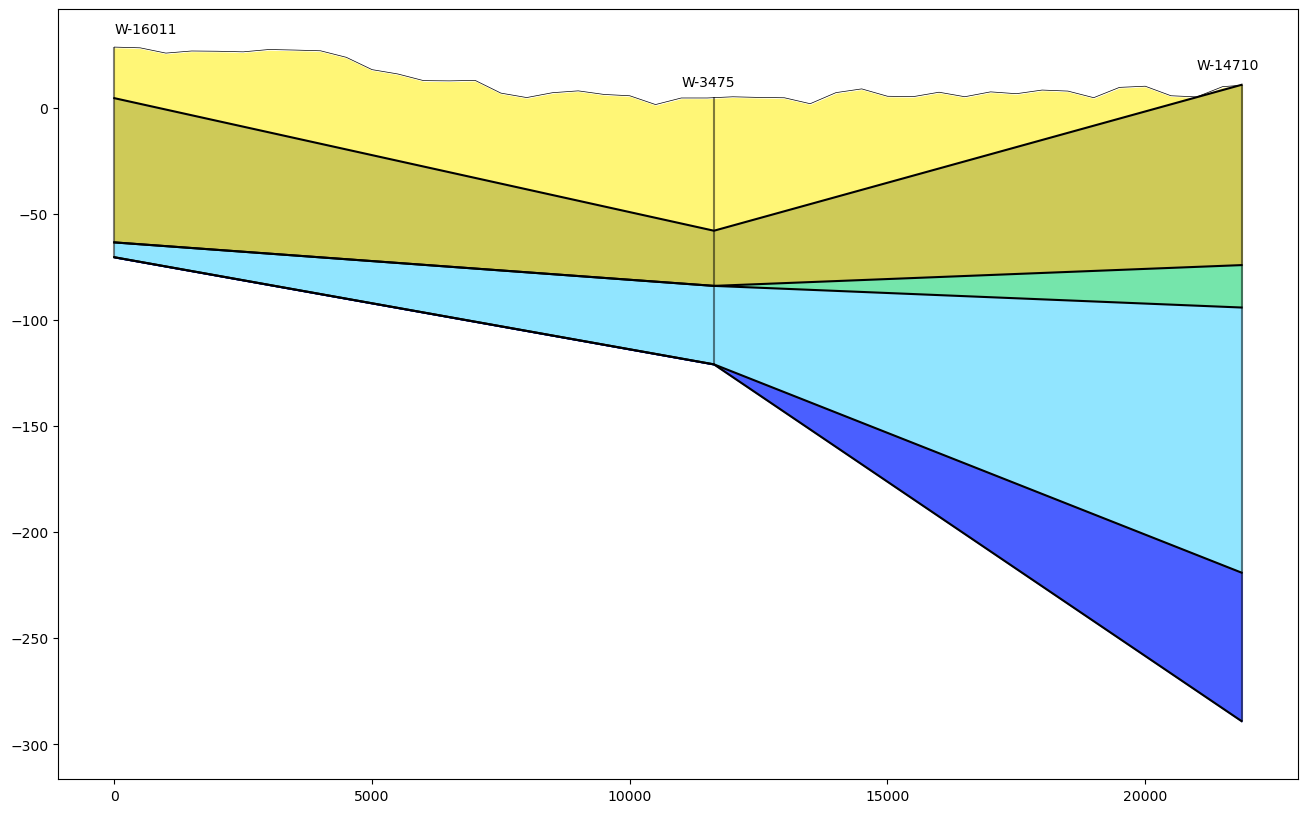

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))

#Plots the surface lithology with the elevation
ax.fill_between(elev_array[1], elev_array[0], color='#FFF676', zorder = 2)
ax.fill_between(distance, elevations, formation_list[0], color='#FFF676', zorder = 2)

#Plots a white cover above elevation to cut off anuy formations that exceed the elevation 
ax.fill_between(elev_array[1], elev_array[0], 30, color='w', zorder=2)

#Plots each formation
ax.fill_between(distance, formation_list[0], formation_list[1], color='#CECA58', zorder=2)
ax.fill_between(distance, formation_list[1], formation_list[2], color='#75E5AB', zorder=2)
ax.fill_between(distance, formation_list[2], formation_list[3], color='#91E5FF', zorder=2)
ax.fill_between(distance, formation_list[3], formation_list[4], color='#4A5FFF', zorder=2)

#Plots a white bottom layer that covers any artifacts
ax.fill_between(distance, formation_list[4], -300, color='w')

#Creates the vertical lines indicating well locations
w1 = ax.vlines(0, color='k', ymin=-70.4, ymax=28.6, zorder=5)
w2 = ax.vlines(11633, color='k', ymin=-120.9, ymax=5.1, zorder=5)
w3 = ax.vlines(21870, color='k', ymin=-289.1, ymax=10.9, zorder=5)

w1.set_alpha(0.5)
w2.set_alpha(0.5)
w3.set_alpha(0.5)

#PLots solid lines for each contact
ax.plot(elev_array[1], elev_array[0], color='k', linewidth=0.5)
ax.plot(distance, formation_list[0], color='k', linestyle='-')
ax.plot(distance, formation_list[1], color='k', linestyle='-')
ax.plot(distance, formation_list[2], color='k', linestyle='-')
ax.plot(distance, formation_list[3], color='k', linestyle='-')
ax.plot(distance, formation_list[4], color='k')

#Creates the text for well number
ax.annotate("W-16011", xy = (0, 35))
ax.annotate("W-3475", xy = (11000, 10))
ax.annotate("W-14710", xy = (21000, 18))

plt.show()